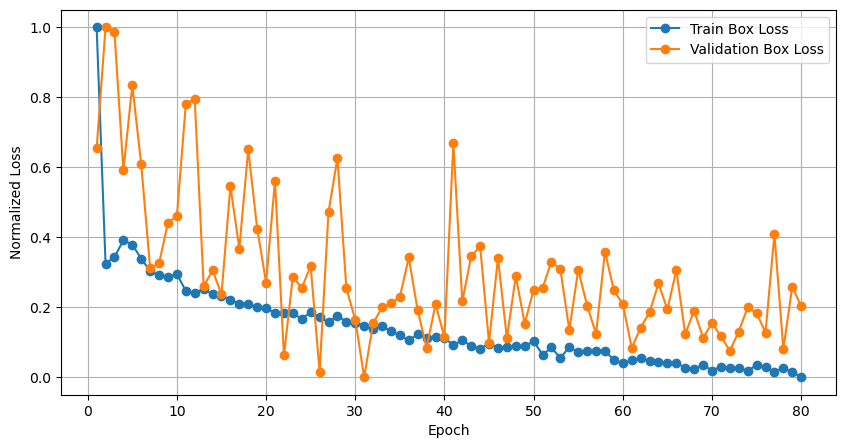

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file_path = 'results_model_1.csv'

data = pd.read_csv(csv_file_path, sep=r'\s*,\s*', engine='python')

data_normalized = (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 5))

plt.plot(data['epoch'], data_normalized['train/box_loss'], label='Train Box Loss', marker='o')
plt.plot(data['epoch'], data_normalized['val/box_loss'], label='Validation Box Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.legend()

plt.grid(True)
plt.show()


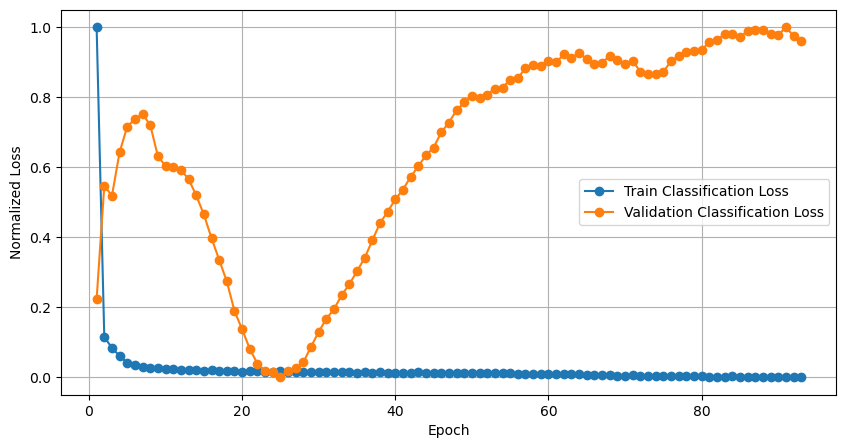

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file_path = 'results_model_2.csv'

data = pd.read_csv(csv_file_path, sep=r'\s*,\s*', engine='python')

data_normalized = (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 5))

plt.plot(data['epoch'], data_normalized['train/cls_loss'], label='Train Classification Loss', marker='o')
plt.plot(data['epoch'], data_normalized['val/cls_loss'], label='Validation Classification Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.legend()

plt.grid(True)
plt.show()


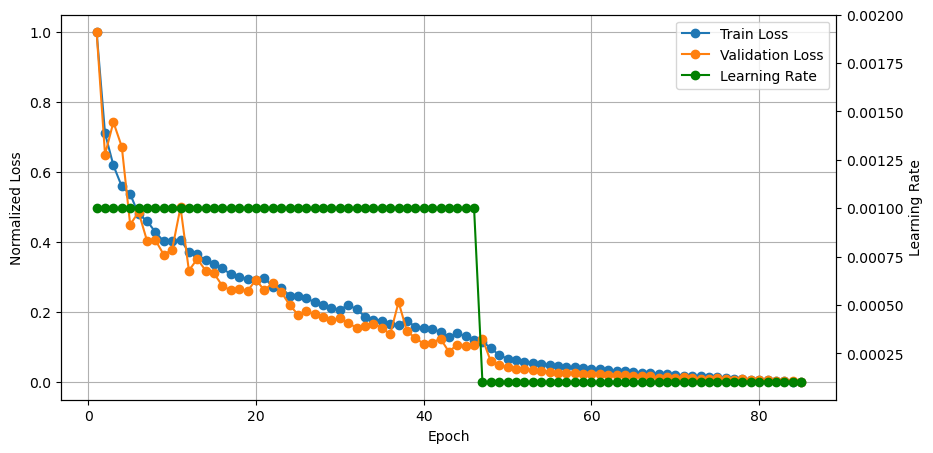

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the .txt file
txt_file_path = 'train_val_loss_model_3.txt'

# Read the .txt file into a DataFrame assuming the data is comma-separated
data = pd.read_csv(txt_file_path, header=None, names=['epoch', 'train_loss', 'val_loss', 'learning_rate'])

# Normalize the loss data
data['train_loss'] = (data['train_loss'] - data['train_loss'].min()) / (data['train_loss'].max() - data['train_loss'].min())
data['val_loss'] = (data['val_loss'] - data['val_loss'].min()) / (data['val_loss'].max() - data['val_loss'].min())

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting train and val loss on the primary y-axis
ax1.plot(data['epoch'], data['train_loss'], label='Train Loss', marker='o')
ax1.plot(data['epoch'], data['val_loss'], label='Validation Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Normalized Loss')
ax1.tick_params(axis='y')

# Create a second y-axis for the learning rate
ax2 = ax1.twinx()
ax2.plot(data['epoch'], data['learning_rate'], label='Learning Rate', marker='o', color='g')
ax2.set_ylabel('Learning Rate')
ax2.set_ylim(0.00001, 0.002)  # Set the limits for the learning rate axis
ax2.tick_params(axis='y')  # Color the tick labels to match the plot for clarity

# Adding legend with combined handlers from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot with grid
ax1.grid(True)
plt.show()


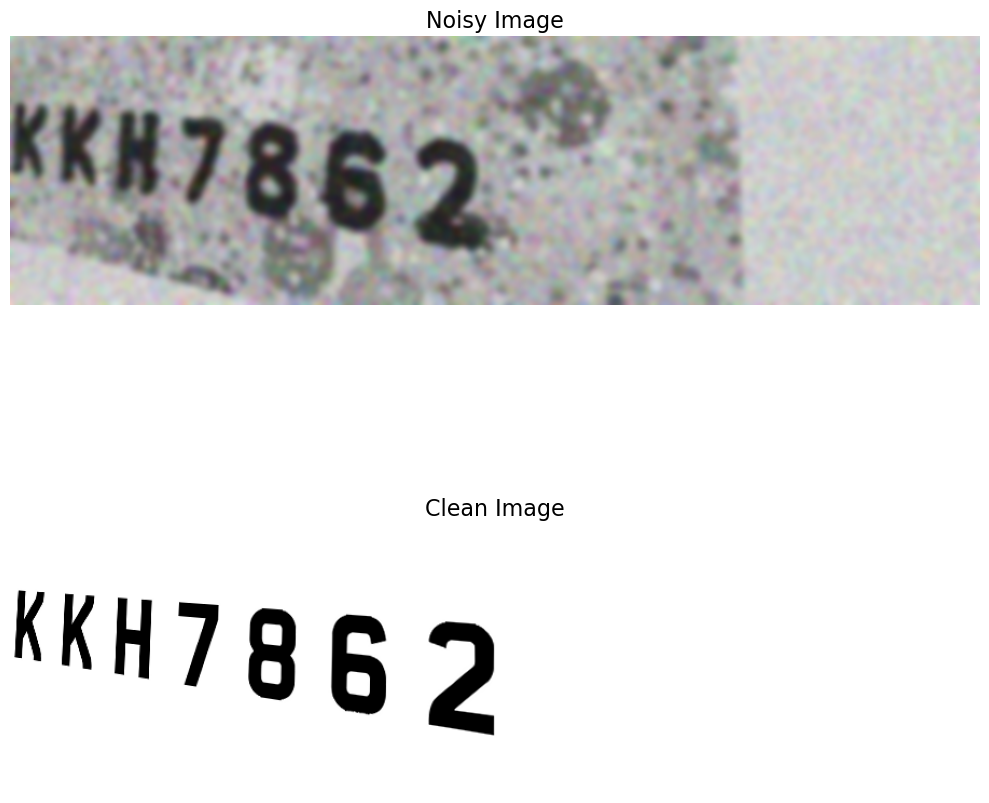

In [26]:
import matplotlib.pyplot as plt
from PIL import Image

# Paths to your images
path_noisy = 'plate_7_noisy.png'  # Path to the noisy image
path_clean = 'plate_7_clean.png'  # Make sure to update the path to the clean image

# Open the images
noisy_image = Image.open(path_noisy)
clean_image = Image.open(path_clean)

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))  # Set nrows to 2 for two horizontal images

# Plot noisy image in the first subplot
axes[0].imshow(noisy_image)
axes[0].set_title('Noisy Image', fontsize=16)  # Increase the font size for the title
axes[0].axis('off')  # Turn off axis numbers and ticks

# Plot clean image in the second subplot
axes[1].imshow(clean_image)
axes[1].set_title('Clean Image', fontsize=16)  # Increase the font size for the title
axes[1].axis('off')  # Turn off axis numbers and ticks

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.05)  # Reduce the horizontal space to a minimum

# Display the results
plt.tight_layout()  # Adjust layout to make sure there is no overlap
plt.show()


In [4]:
import torch
import torch.nn as nn
from torchviz import make_dot

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = self.conv_block(1, 64)
        self.down2 = self.conv_block(64, 128, pool=True)
        self.down3 = self.conv_block(128, 256, pool=True)
        self.down4 = self.conv_block(256, 512, pool=True)
        self.down5 = self.conv_block(512, 1024, pool=True)
        self.down6 = self.conv_block(1024, 2048, pool=True)
        self.bottleneck = self.conv_block(2048, 2048)
        self.up5 = self.up_conv_block(2048, 1024)
        self.up4 = self.up_conv_block(1024, 512)
        self.up3 = self.up_conv_block(512, 256)
        self.up2 = self.up_conv_block(256, 128)
        self.up1 = self.up_conv_block(128, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels, pool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        ]
        if pool:
            layers.insert(0, nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        # Track each stage to ensure visibility in graph
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)

        x_bottleneck = self.bottleneck(x6)

        x = self.up5(x_bottleneck) + x5
        x = self.up4(x) + x4
        x = self.up3(x) + x3
        x = self.up2(x) + x2
        x = self.up1(x) + x1

        output = self.final(x)
        output = self.sigmoid(output)
        return output

def create_unet_diagram():
    device = torch.device("cpu")
    model = UNet().to(device)
    x = torch.randn(1, 1, 256, 256).to(device)  # Simulate an input
    out = model(x)
    dot = make_dot(out, params=dict(list(model.named_parameters()) + [('input', x)]))
    dot.render('unet_model_diagram', format='png', directory='./diagrams')  # Save diagram

if __name__ == "__main__":
    create_unet_diagram()


In [14]:
import graphviz

# Define the pipeline steps
steps = [
    "Read Video",
    "License Plate Detection (Model 1)",
    "Crop Image",
    "Character Detection (Model 2)",
]

# Define the connections between steps
connections = [
    ("Read Video", "License Plate Detection (Model 1)"),
    ("License Plate Detection (Model 1)", "Crop Image"),
    ("Crop Image", "Character Detection (Model 2)"),
]

# Create a graph
dot = graphviz.Digraph()
dot.graph_attr['rankdir'] = 'TB'  # Top to bottom layout

# Add nodes to the graph
for step in steps:
    dot.node(step, shape='rectangle')  # Rectangular shape

# Add edges to the graph
for connection in connections:
    dot.edge(*connection)

# Render the graph
dot.render("pipeline", format="png", cleanup=True)


'pipeline.png'

In [20]:
import graphviz

# Define the pipeline steps with specific image adjustments
steps = [
    "Read Video",
    "License Plate Detection (Model 1)",
    "Crop Image",
    "Grayscale Conversion",
    "CLAHE Enhancement",
    "Binary Threshold",
    "Character Detection (Model 2)",
]

# Define the connections between steps
connections = [
    ("Read Video", "License Plate Detection (Model 1)"),
    ("License Plate Detection (Model 1)", "Crop Image"),
    ("Crop Image", "Grayscale Conversion"),
    ("Grayscale Conversion", "CLAHE Enhancement"),
    ("CLAHE Enhancement", "Binary Threshold"),
    ("Binary Threshold", "Character Detection (Model 2)"),
]

# Create a graph
dot = graphviz.Digraph()
dot.graph_attr['rankdir'] = 'TB'  # Top to bottom layout

# Add nodes to the graph
for step in steps:
    dot.node(step, shape='rectangle')  # Rectangular shape

# Add edges to the graph
for connection in connections:
    dot.edge(*connection)

# Render the graph
dot.render("pipeline_with_image_adjustments", format="png", cleanup=True)


'pipeline_with_image_adjustments.png'

In [19]:
import graphviz

# Define the pipeline steps with specific image adjustments and EasyOCR
steps = [
    "Read Video",
    "License Plate Detection (Model 1)",
    "Crop Image",
    "Grayscale Conversion",
    "CLAHE Enhancement",
    "Binary Threshold",
    "Character Detection (EasyOCR)",
]

# Define the connections between steps
connections = [
    ("Read Video", "License Plate Detection (Model 1)"),
    ("License Plate Detection (Model 1)", "Crop Image"),
    ("Crop Image", "Grayscale Conversion"),
    ("Grayscale Conversion", "CLAHE Enhancement"),
    ("CLAHE Enhancement", "Binary Threshold"),
    ("Binary Threshold", "Character Detection (EasyOCR)"),
]

# Create a graph
dot = graphviz.Digraph()
dot.graph_attr['rankdir'] = 'TB'  # Top to bottom layout

# Add nodes to the graph
for step in steps:
    dot.node(step, shape='rectangle')  # Rectangular shape

# Add edges to the graph
for connection in connections:
    dot.edge(*connection)

# Render the graph
dot.render("pipeline_with_easyocr", format="png", cleanup=True)


'pipeline_with_easyocr.png'

In [15]:
import graphviz

# Define the pipeline steps with specific image adjustments and PyTorch model
steps = [
    "Read Video",
    "License Plate Detection (Model 1)",
    "Crop Image",
    "Upscale Image",
    "Convert to Grayscale",
    "Denoising (Model 3)",
    "Character Detection (Model 2)",
]

# Define the connections between steps
connections = [
    ("Read Video", "License Plate Detection (Model 1)"),
    ("License Plate Detection (Model 1)", "Crop Image"),
    ("Crop Image", "Upscale Image"),
    ("Upscale Image", "Convert to Grayscale"),
    ("Convert to Grayscale", "Denoising (Model 3)"),
    ("Denoising (Model 3)", "Character Detection (Model 2)"),
]

# Create a graph
dot = graphviz.Digraph()
dot.graph_attr['rankdir'] = 'TB'  # Top to bottom layout

# Add nodes to the graph
for step in steps:
    dot.node(step, shape='rectangle')  # Rectangular shape

# Add edges to the graph
for connection in connections:
    dot.edge(*connection)

# Render the graph
dot.render("pipeline_with_pytorch", format="png", cleanup=True)


'pipeline_with_pytorch.png'

In [21]:
import graphviz

# Define the pipeline steps with specific image adjustments
steps = [
    "Read Video",
    "License Plate Detection (Model 1)",
    "Crop Image",
    "Adaptive Threshold",
    "Character Detection (Model 2)",
]

# Define the connections between steps
connections = [
    ("Read Video", "License Plate Detection (Model 1)"),
    ("License Plate Detection (Model 1)", "Crop Image"),
    ("Crop Image", "Adaptive Threshold"),
    ("Adaptive Threshold", "Character Detection (Model 2)"),
]

# Create a graph
dot = graphviz.Digraph()
dot.graph_attr['rankdir'] = 'TB'  # Top to bottom layout

# Add nodes to the graph
for step in steps:
    dot.node(step, shape='rectangle')  # Rectangular shape

# Add edges to the graph
for connection in connections:
    dot.edge(*connection)

# Render the graph
dot.render("pipeline_with_opencv", format="png", cleanup=True)


'pipeline_with_opencv.png'

Average Accuracies by Experiment:
  Experiment  Accuracy
0          1  0.368500
1          2  0.147500
2          3  0.313000
3          4  0.423500
4   Baseline  0.314815


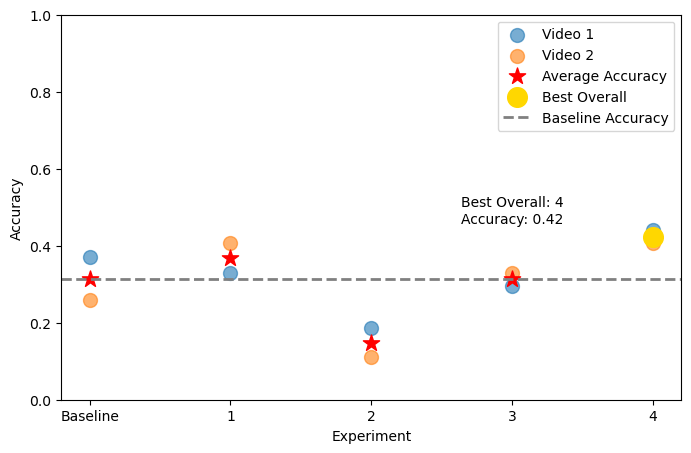

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Existing data
data = {
    'Experiment': ['Baseline', 'Baseline'] + ['1', '2', '3', '4'] * 2,
    'Accuracy': [0.37037037037037035, 0.25925925925925924] + [0.33, 0.185, 0.296, 0.44, 0.407, 0.11, 0.33, 0.407],
    'Video': ['1', '2'] + ['1'] * 4 + ['2'] * 4
}

df = pd.DataFrame(data)

# Group by Experiment and calculate mean Accuracy across videos
average_accuracy = df.groupby('Experiment')['Accuracy'].mean().reset_index()

# Find the experiment with the highest average accuracy
best_experiment = average_accuracy.loc[average_accuracy['Accuracy'].idxmax()]

# Calculate baseline accuracy
baseline_accuracy = average_accuracy[average_accuracy['Experiment'] == 'Baseline']['Accuracy'].values[0]

# Print average accuracies for each experiment
print("Average Accuracies by Experiment:")
print(average_accuracy)

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.viridis(df['Accuracy'] / df['Accuracy'].max())  # Normalizing colors to the accuracy

# Scatter plot for individual scores
for video, group in df.groupby('Video'):
    ax.scatter(group['Experiment'], group['Accuracy'], s=100, label=f"Video {video}", alpha=0.6)

# Highlight the mean accuracy across videos for each experiment
ax.scatter(average_accuracy['Experiment'], average_accuracy['Accuracy'], s=150, c='red', label='Average Accuracy', marker='*')

# Emphasize the best experiment
ax.scatter(best_experiment['Experiment'], best_experiment['Accuracy'], s=200, color='gold', label='Best Overall', marker='o')

# Horizontal line for the baseline accuracy
ax.axhline(y=baseline_accuracy, color='gray', linestyle='--', linewidth=2, label='Baseline Accuracy')

ax.set_xlabel('Experiment')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.legend()

# Annotating the best experiment
ax.annotate(f"Best Overall: {best_experiment['Experiment']}\nAccuracy: {best_experiment['Accuracy']:.2f}",
             xy=(average_accuracy.index[average_accuracy['Experiment'] == best_experiment['Experiment']].tolist()[0], best_experiment['Accuracy']),
             textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


ValueError: num must be an integer with 1 <= num <= 5, not 6

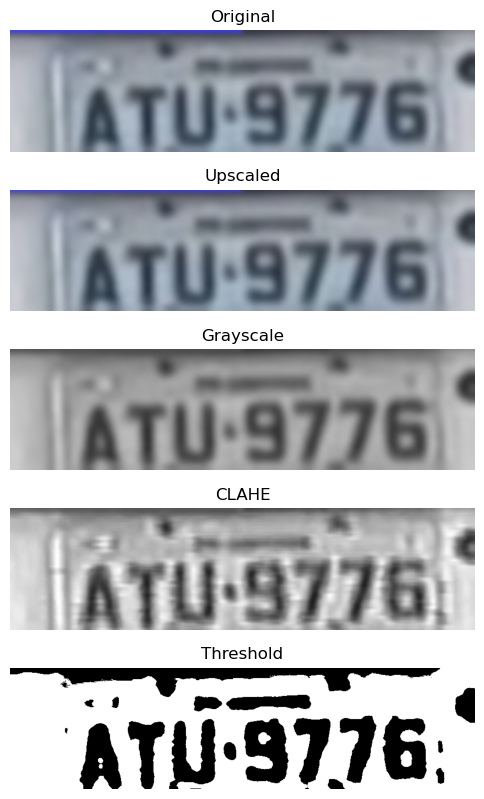

In [30]:
import cv2
import matplotlib.pyplot as plt

def upscale_gaussian_pyramid(image, n):
    upscaled_image = image
    for _ in range(n):
        upscaled_image = cv2.pyrUp(upscaled_image)
    return upscaled_image

def increase_contrast(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(45, 45))
    enhanced_gray = clahe.apply(gray)
    # Apply threshold
    _, binary_image = cv2.threshold(enhanced_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Detect edges
    edges = cv2.Canny(binary_image, 100, 200)
    # Combine binary image and edges
    enhanced_text_image = cv2.bitwise_or(binary_image, edges)
    
    return gray, enhanced_gray, binary_image, edges, enhanced_text_image

# Load the image
image = cv2.imread('out1put.png')  # Ensure this is the correct path to your image
upscaled_image = upscale_gaussian_pyramid(image, 1)  # Adjust based on your requirement

# Process the image
steps = increase_contrast(upscaled_image)

# Plotting all steps
step_names = ['Original', 'Upscaled', 'Grayscale', 'CLAHE', 'Threshold']
images = [image, upscaled_image] + list(steps)

plt.figure(figsize=(6, 10))  # Adjust figure size to fit vertical layout better
for i, img in enumerate(images):
    plt.subplot(5, 1, i + 1)  # 7 rows, 1 column
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for plotting
    plt.title(step_names[i])
    plt.axis('off')

plt.subplots_adjust(hspace=0.005)  # Reduce the horizontal space to make plots closer
plt.tight_layout()
plt.show()

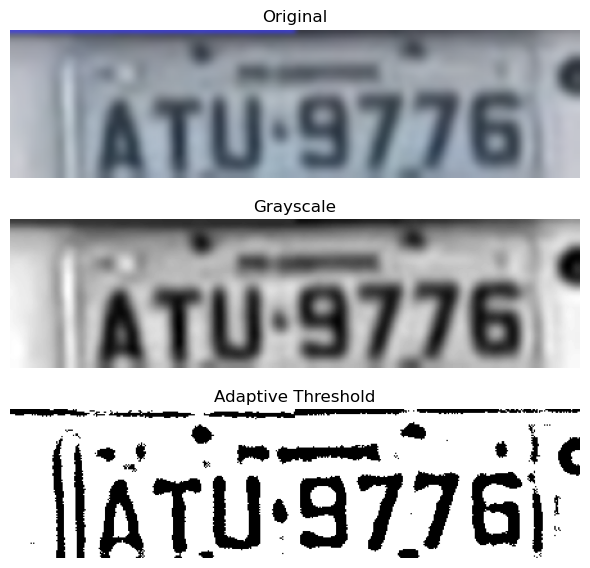

In [2]:
import cv2
import matplotlib.pyplot as plt

def apply_adaptive_thresholding(image):
    # Check if image is in color and convert to grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Apply adaptive thresholding
    adaptive_thresh_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                  cv2.THRESH_BINARY, 11, 2)

    return gray_image, adaptive_thresh_image

# Load the image
image = cv2.imread('out1put.png')  # Ensure this is the correct path to your image

# Process the image
gray_image, adaptive_thresh_image = apply_adaptive_thresholding(image)

# Plotting the original and processed images
step_names = ['Original', 'Grayscale', 'Adaptive Threshold']
images = [image, gray_image, adaptive_thresh_image]

plt.figure(figsize=(6, 6))  # Adjust figure size to fit three images vertically
for i, img in enumerate(images):
    plt.subplot(3, 1, i + 1)  # 3 rows, 1 column
    if i == 0:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for original image plotting
    else:
        plt.imshow(img, cmap='gray')  # Plot grayscale and threshold images in grayscale
    plt.title(step_names[i])
    plt.axis('off')

plt.subplots_adjust(hspace=0.01)  # Minimize the space between plots
plt.tight_layout()
plt.show()


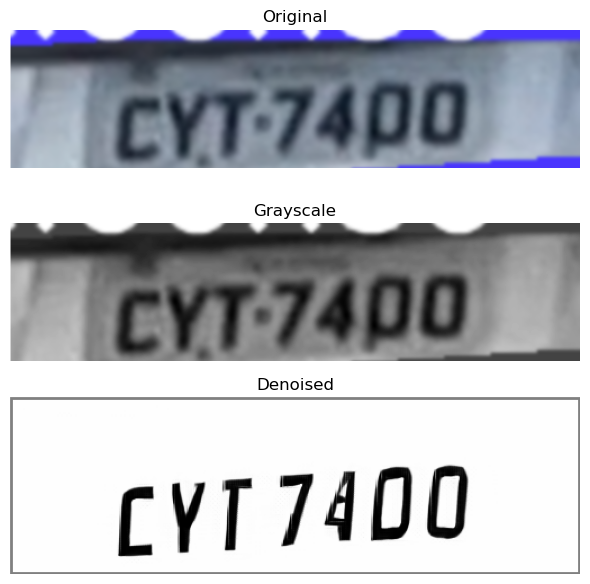

In [13]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Load the original and denoised images from files
original_image = cv2.imread('model_3_before_denoise.png')  # Update path to your original image file
denoised_image = cv2.imread('model_3_after_denoise.png')  # Update path to your denoised image file

# Ensure both images are read correctly
if original_image is None or denoised_image is None:
    print("Error loading images")
    exit()

# Convert original image to grayscale
original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Plotting the original (color), original (grayscale), and denoised images
step_names = ['Original', 'Grayscale', 'Denoised']
images = [original_image, original_image_gray, denoised_image]

plt.figure(figsize=(6, 6))  # Adjust figure size to fit three images vertically
for i, img in enumerate(images):
    ax = plt.subplot(3, 1, i + 1)  # 3 rows, 1 column
    if i == 0:
        # Display the original image in RGB
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elif i == 1:
        # Display the grayscale image
        plt.imshow(img, cmap='gray')
    else:
        # Display the denoised image in RGB
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(step_names[i])
    plt.axis('off')

    # Add a border around the denoised image
    if step_names[i] == 'Denoised':
        # Adding a rectangle patch with no fill, setting edgecolor to gray and linewidth
        rect = Rectangle((0, 0), img.shape[1]-1, img.shape[0]-1, linewidth=2, edgecolor='gray', facecolor='none')
        ax.add_patch(rect)

plt.subplots_adjust(hspace=0.01)  # Minimize the space between plots
plt.tight_layout()
plt.show()


In [16]:
import os
import cv2
from PIL import Image as PILImage
from utilities.image_methods.image_enhancing import ImageEnhancing
from utilities.image_methods.utils import Utils
from ultralytics import YOLO

# Set environment variable
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Initialize utilities
utils = Utils()
image_enhancing = ImageEnhancing()

# Load models
license_plate_detection = YOLO('../all_models/model_1_trained_for_license_plate_detection/weights/best.pt')
character_detection = YOLO('../all_models/model_2_trained_for_character_detection/weights/best.pt')

# Font settings for CV2
font_scale = 2
font_color = (0, 255, 0)
thickness = 3
line_type = cv2.LINE_AA
font = cv2.FONT_HERSHEY_SIMPLEX
VIDEO_PATH_2 = '../all_datasets/dataset_4_videos/Video2.mp4'
TEXT_FILE_PATH = 'detected_texts.txt'

# Video capture setup
cap = cv2.VideoCapture(VIDEO_PATH_2)
if not cap.isOpened():
    print("Error: Cannot open video file.")
    exit()

while True:
    success, frame = cap.read()
    if not success:
        print("Finished playing video or failed to read frame.")
        break

    results = license_plate_detection(frame)
    annotated_frame = frame.copy()

    # Detects license plates (assuming Tensor with class 0)
    for r in results:
        for k in r.obb:
            if k.cls == 0:
                # Image adjustments below this line
                im_array = r.plot()  # This assumes r.plot() returns an image with bounding boxes already drawn.
                cropped_image = utils.crop_image_license(frame, k.xyxyxyxy)
                enhanced_text_image = image_enhancing.apply_adaptive_thresholding(cropped_image)

                # Convert enhanced image to BGR if it's grayscale for display purposes
                if len(enhanced_text_image.shape) == 2:  # Check if image is grayscale
                    enhanced_text_image = cv2.cvtColor(enhanced_text_image, cv2.COLOR_GRAY2BGR)
                    enhanced_text_image = cv2.resize(enhanced_text_image, (600, 250))

                results_chars = character_detection(enhanced_text_image)
                for m in results_chars:
                    for n in r.obb:
                        im_array2 = m.plot()
            
                        # Display the enhanced text image in its own window
                        cv2.imshow('Enhanced License Plate', im_array2)

                # Character detection and processing
                detected_chars = utils.detect_characters(character_detection, PILImage.fromarray(enhanced_text_image), conf=0.7, spacing_threshold=70)
                detected_text = ''.join(detected_chars)

                # Shows detected characters on the frame for illustration
                frame_height, frame_width = im_array.shape[:2]
                text_size = cv2.getTextSize(detected_text, font, font_scale, thickness)[0]
                text_x = int((frame_width - text_size[0]) / 2)
                text_y = frame_height - 50  # Offset from bottom
                cv2.putText(im_array, detected_text, (text_x, text_y), font, font_scale, font_color, thickness, line_type)

                # Writes detected characters to file
                with open(TEXT_FILE_PATH, 'a') as file:
                    file.write(detected_text + '\n')

    # Display the annotated main video frame
    cv2.imshow('Video', im_array)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
        break

# Release resources
cap.release()
cv2.destroyAllWindows()



0: 736x1280 146.6ms
Speed: 7.0ms preprocess, 146.6ms inference, 5.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 128x256 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 4.0ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 128, 256)

0: 736x1280 13.6ms
Speed: 6.5ms preprocess, 13.6ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 128x256 12.2ms
Speed: 1.0ms preprocess, 12.2ms inference, 4.3ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 2.8ms postprocess per image at shape (1, 3, 128, 256)

0: 736x1280 (no detections), 12.9ms
Speed: 6.2ms preprocess, 12.9ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 10.7ms
Speed: 5.0ms preprocess, 10.7ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 128x256 15.6ms
Speed: 0.0ms preprocess, 1

In [ ]:
results = license_plate_detection('./illustrations/illustration_image.png')
cropped_image = None
upscaled_image = None
downscaled_image = None

for r in results:
    im_array = r.plot()
    img = PILImage.fromarray(im_array)
    width, height = img.size
    resize_factor = 0.5 
    img_resized = img.resize((int(width * resize_factor), int(height * resize_factor)))
    display(img_resized)
    
    for k in r.obb:
        if k.cls == 0:
            cropped_image = Utils.crop_image_license(utils, im_array, k.xyxyxyxy)
            
            # upscaling the image using gaussian pyramid in order to make the features easier to detect later
            upscaled_image = ImageEnhancing.upscale_gaussian_pyramid(image_enhancing, cropped_image, 3)
            upscaled_width, upscaled_height = upscaled_image.shape[1], upscaled_image.shape[0]
            
            # downscaling for displaying 
            downscale_factor = 0.5
            downscaled_image = PILImage.fromarray(upscaled_image).resize(
                (int(upscaled_width * downscale_factor), int(upscaled_height * downscale_factor))
            )
            display(downscaled_image)